In [1]:
#import matplotlib.pyplot as plt
#import PIL
#from PIL import Image
import pims
import numpy as np
import cv2
import tensorflow as tf
import random
#import slicerator
#import skimage
import tifffile
from tifffile import imwrite
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model, load_model
import visualkeras
from PIL import ImageFont
from tqdm import tqdm
import time
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
import matplotlib.pyplot as plt
import gc
import skimage
import pandas as pd
from pathlib import Path

In [2]:
scan_path = Path(r'C:\Users\mihin\OneDrive\Documents\FYPRepo\sample-masks-2\sample-masks-2~\sample-masks\scans')
mask_path = Path(r'C:\Users\mihin\OneDrive\Documents\FYPRepo\sample-masks-2\sample-masks-2~\sample-masks\masks')
model_path = r'G:\My Drive\Course Units\FYP\Notebooks\Final U-Net Model'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 14GB of memory on the GPU
  try:
    #tf.config.set_logical_device_configuration(
        #gpus[0],
        #[tf.config.LogicalDeviceConfiguration(memory_limit=14336)])
    tf.config.experimental.set_memory_growth(gpus[0], True)
    logical_gpu = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpu), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [4]:
#CONSTANTS
SIZE_X = 128
SIZE_Y = 128
n_classes = 2 #Background and lung tissue
TRAIN_SPLIT_SIZE = 10

In [5]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   # Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  # Not in the original network
    x = Activation("relu")(x)

    return x

# Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

# Decoder block
# Skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  # Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  # Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [6]:
scan_path = Path(r'C:\Users\mihin\OneDrive\Documents\FYPRepo\sample-masks-2\sample-masks-2~\sample-masks\scans')
scans = [file.stem for file in scan_path.rglob('*.tif')] #select only '.tif' files
scans = sorted(scans)

mask_path = Path(r'C:\Users\mihin\OneDrive\Documents\FYPRepo\sample-masks-2\sample-masks-2~\sample-masks\masks')
masks = [file.stem for file in mask_path.rglob('*.tif')] 
masks = sorted(masks)

all_paths = [scans,masks]
all_paths = np.transpose(np.array(all_paths, dtype=str))
print(all_paths)
print(all_paths.shape)

[['21-1-M39-R01_T06.crop' '21-1-M39-R01.mask.07']
 ['21-2-M67-R01_T06.crop' '21-2-M67-R01.mask.06']
 ['21-2-M67-R02_T04.crop' '21-2-M67-R02.mask.04']
 ['21-2-M67-R03_T13.crop' '21-2-M67-R03.mask.13']
 ['21-2-M68-R01_T01.crop' '21-2-M68-R01.mask.01']
 ['21-2-M68-R02_T10.crop' '21-2-M68-R02.mask.10']
 ['21-2-M68-R03_T04.crop' '21-2-M68-R03.mask.04']
 ['21-2-M69-R01_T04.crop' '21-2-M69-R01.mask.04']
 ['21-2-M69-R02_T05.crop' '21-2-M69-R02.mask.05']
 ['21-2-M70-R01_T11.crop' '21-2-M70-R01.mask.11']
 ['21-2-M70-R02_T04.crop' '21-2-M70-R02.mask.04']
 ['21-2-M70-R03_T02.crop' '21-2-M70-R03.mask.02']
 ['21-2-M71-R01_T06.crop' '21-2-M71-R01.mask.06']
 ['21-2-M71-R02_T01.crop' '21-2-M71-R02.mask.01']
 ['21-2-M71-R03_T10.crop' '21-2-M71-R03.mask.10']
 ['21-2-M72-R01_T06.crop' '21-2-M72-R01.mask.06']
 ['21-2-M72-R02_T14.crop' '21-2-M72-R02.mask.14']
 ['21-2-M72-R03_T09.crop' '21-2-M72-R03.mask.09']]
(18, 2)


In [7]:
np.random.shuffle(all_paths)
train_paths = all_paths[0:TRAIN_SPLIT_SIZE,:]
val_paths = all_paths[-8:-4,:]
test_paths = all_paths[-4:,:]

print('File Paths Split!')


train_scans = []
for stack in tqdm(range(train_paths.shape[0])):
    scan_stack_path = r'C:/Users/mihin/OneDrive/Documents/FYPRepo/sample-masks-2/sample-masks-2~/sample-masks/scans/' + train_paths[stack,0] + '.tif'
    tif_scan = pims.open(scan_stack_path)
    tif_scan = np.array(tif_scan)
    for idx in tqdm(range(tif_scan.shape[0]),leave=False):
        img = cv2.resize(tif_scan[idx], (SIZE_Y, SIZE_X))
        train_scans.append(img)

train_masks = []
for stack in tqdm(range(train_paths.shape[0])):
    mask_stack_path = r'C:/Users/mihin/OneDrive/Documents/FYPRepo/sample-masks-2/sample-masks-2~/sample-masks/masks/' + train_paths[stack,1] + '.tif'
    tif_mask = pims.open(mask_stack_path)
    tif_mask = np.array(tif_mask)
    for idx in range(tif_mask.shape[0]):
        img = cv2.resize(tif_mask[idx], (SIZE_Y, SIZE_X))
        train_masks.append(img)

val_scans = []
for stack in tqdm(range(val_paths.shape[0])):
    scan_stack_path = r'C:/Users/mihin/OneDrive/Documents/FYPRepo/sample-masks-2/sample-masks-2~/sample-masks/scans/' + val_paths[stack,0] + '.tif'
    tif_scan = pims.open(scan_stack_path)
    tif_scan = np.array(tif_scan)
    for idx in tqdm(range(tif_scan.shape[0]),leave=False):
        img = cv2.resize(tif_scan[idx], (SIZE_Y, SIZE_X))
        val_scans.append(img)

val_masks = []
for stack in tqdm(range(val_paths.shape[0])):
    mask_stack_path = r'C:/Users/mihin/OneDrive/Documents/FYPRepo/sample-masks-2/sample-masks-2~/sample-masks/masks/' + val_paths[stack,1] + '.tif'
    tif_mask = pims.open(mask_stack_path)
    tif_mask = np.array(tif_mask)
    for idx in range(tif_mask.shape[0]):
        img = cv2.resize(tif_mask[idx], (SIZE_Y, SIZE_X))
        val_masks.append(img)

test_scans = []
for stack in tqdm(range(test_paths.shape[0])):
    scan_stack_path = r'C:/Users/mihin/OneDrive/Documents/FYPRepo/sample-masks-2/sample-masks-2~/sample-masks/scans/' + test_paths[stack,0] + '.tif'
    tif_scan = pims.open(scan_stack_path)
    tif_scan = np.array(tif_scan)
    for idx in range(tif_scan.shape[0]):
        img = cv2.resize(tif_scan[idx], (SIZE_Y, SIZE_X))
        test_scans.append(img)

test_masks = []
for stack in tqdm(range(test_paths.shape[0])):
    mask_stack_path = r'C:/Users/mihin/OneDrive/Documents/FYPRepo/sample-masks-2/sample-masks-2~/sample-masks/masks/' + test_paths[stack,1] + '.tif'
    tif_mask = pims.open(mask_stack_path)
    tif_mask = np.array(tif_mask)
    for idx in range(tif_mask.shape[0]):
        img = cv2.resize(tif_mask[idx], (SIZE_Y, SIZE_X))
        test_masks.append(img)

train_scans = np.array(train_scans)
train_scans = np.expand_dims(train_scans, axis = 3)

train_masks = np.array(train_masks)
train_masks = np.expand_dims(train_masks, axis = 3)

val_scans = np.array(val_scans)
val_scans = np.expand_dims(val_scans, axis = 3)

val_masks = np.array(val_masks)
val_masks = np.expand_dims(val_masks, axis = 3)

test_scans = np.array(test_scans)
test_scans = np.expand_dims(test_scans, axis = 3)

test_masks = np.array(test_masks)
test_masks = np.expand_dims(test_masks, axis = 3)

print('Datasets Imported!')

File Paths Split!


100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


Datasets Imported!


In [8]:
train_masks_cat = to_categorical(train_masks, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((train_masks.shape[0], train_masks.shape[1], train_masks.shape[2], n_classes))

val_masks_cat = to_categorical(val_masks, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((val_masks.shape[0], val_masks.shape[1], val_masks.shape[2], n_classes))

IMG_HEIGHT = train_scans.shape[1]
IMG_WIDTH  = train_scans.shape[2]
IMG_CHANNELS = train_scans.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

softmax


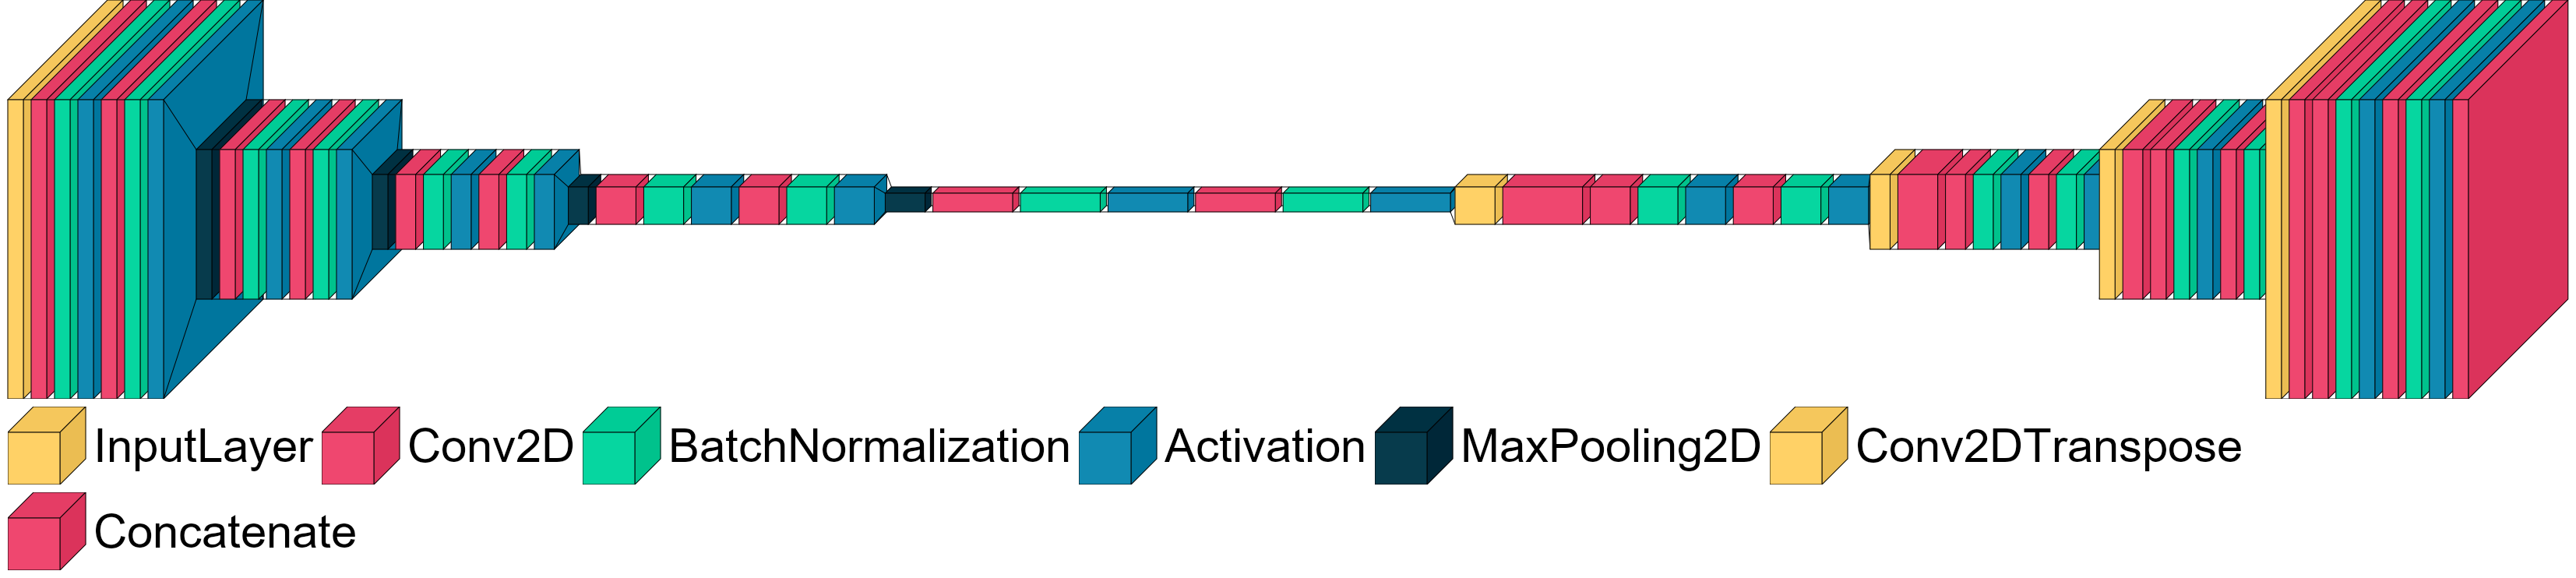

In [9]:
model = build_unet(input_shape, n_classes=2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#visualise layers
font = ImageFont.truetype("arial.ttf", 60)
visualkeras.layered_view(model, draw_volume=True, legend=True, scale_xy=3,font=font)

In [10]:

print('Begin training.....')
startClock = time.time()

history = model.fit(train_scans, y_train_cat, 
                batch_size = 5, 
                verbose=1, 
                epochs=10, 
                validation_data=(val_scans, y_val_cat), 
                shuffle=True)

endClock = time.time()
print('Training Completed')
execTime = endClock - startClock


Begin training.....
Epoch 1/10
2160/2160 [==============================] - 249s 109ms/step - loss: 0.0153 - accuracy: 0.9947 - val_loss: 0.0087 - val_accuracy: 0.9964
Epoch 2/10
2160/2160 [==============================] - 239s 111ms/step - loss: 0.0094 - accuracy: 0.9962 - val_loss: 0.0088 - val_accuracy: 0.9964
Epoch 3/10
2160/2160 [==============================] - 239s 111ms/step - loss: 0.0092 - accuracy: 0.9963 - val_loss: 0.0107 - val_accuracy: 0.9955
Epoch 4/10
2160/2160 [==============================] - 243s 112ms/step - loss: 0.0082 - accuracy: 0.9966 - val_loss: 0.0080 - val_accuracy: 0.9967
Epoch 5/10
2160/2160 [==============================] - 246s 114ms/step - loss: 0.0072 - accuracy: 0.9970 - val_loss: 0.0080 - val_accuracy: 0.9967
Epoch 6/10
2160/2160 [==============================] - 245s 113ms/step - loss: 0.0080 - accuracy: 0.9968 - val_loss: 0.0081 - val_accuracy: 0.9966
Epoch 7/10
2160/2160 [==============================] - 245s 113ms/step - loss: 0.0065 - acc

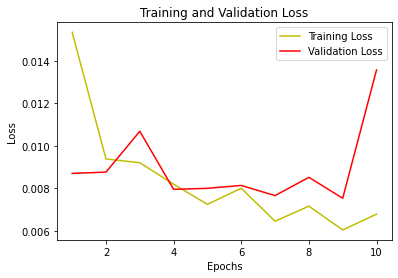

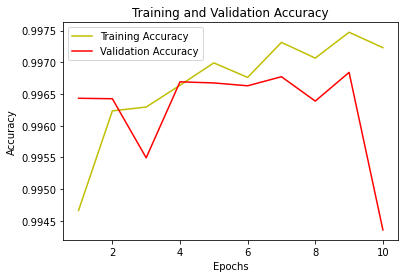

INFO:tensorflow:Assets written to: G:\My Drive\Course Units\FYP\Notebooks\Final U-Net Model\assets


In [11]:

#Plot Loss and Accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.save(model_path)

In [12]:
model = tf.keras.models.load_model(model_path)

In [13]:
y_pred=model.predict(test_scans)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax = y_pred_argmax.astype(np.uint8)
y_pred_argmax = np.expand_dims(y_pred_argmax, axis = 3)

In [14]:
TP = np.sum(np.logical_and(y_pred_argmax == 1, test_masks == 1))
TN = np.sum(np.logical_and(y_pred_argmax == 0, test_masks == 0))
FP = np.sum(np.logical_and(y_pred_argmax == 1, test_masks == 0))
FN = np.sum(np.logical_and(y_pred_argmax == 0, test_masks == 1))
print('IoU: ', TP/(TP+FP+FN))
print("DSC: ", 2*TP/(2*TP+FP+FN))
print("Sensitivity: ", TP/(TP+FN))
print("Specificity: ", TN/(TN+FP))

IoU:  0.9378978687638316
DSC:  0.9679538678290704
Sensitivity:  0.9440364948820192
Specificity:  0.9994417341190661


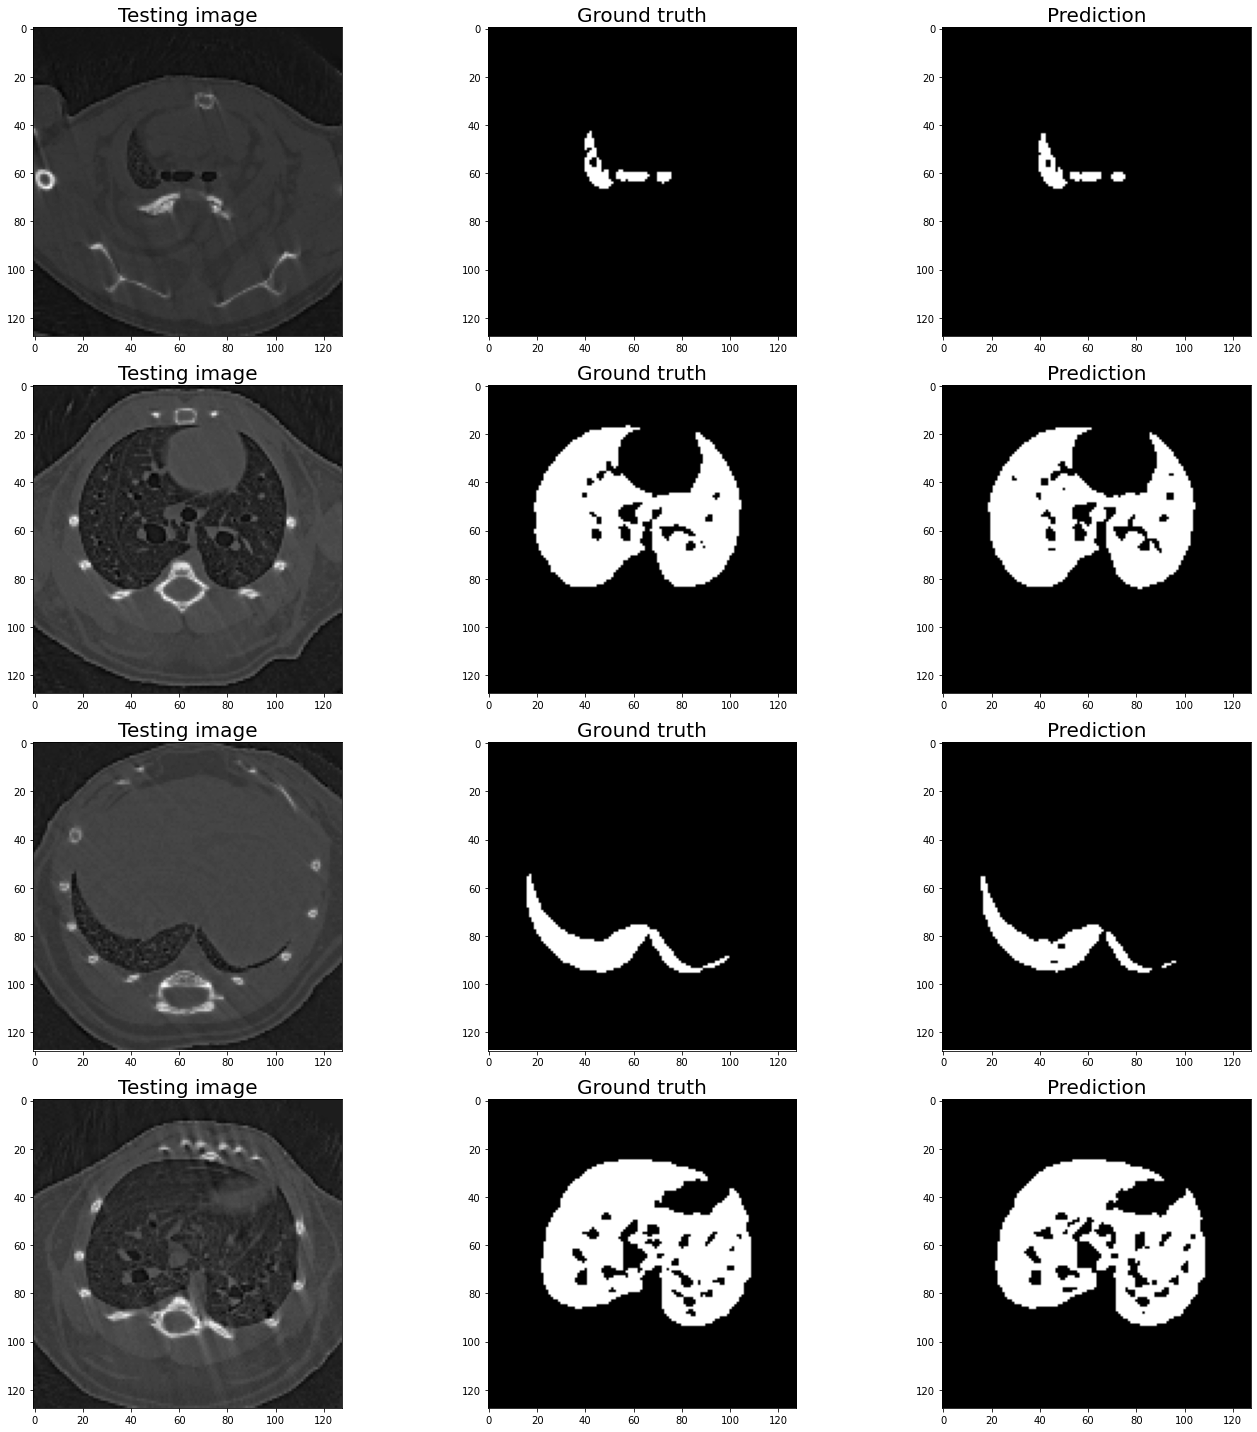

In [16]:
#predict and plot some validation images
no_pred = 4
fig, axs = plt.subplots(no_pred,3,figsize=(20, 20))
for test in range(no_pred):
  test_img_number = random.randint(0, len(test_scans)-1)
  test_img = test_scans[test_img_number]
  ground_truth=test_masks[test_img_number]
  test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img_norm, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]

  axs[test,0].set_title('Testing image', fontsize = 20)
  axs[test,0].imshow(test_img[:,:,0], cmap='gray')
  axs[test,1].set_title('Ground truth', fontsize = 20)
  axs[test,1].imshow(ground_truth[:,:,0], cmap='gray')
  axs[test,2].set_title('Prediction', fontsize = 20)
  axs[test,2].imshow(predicted_img, cmap='gray')
fig.tight_layout()